步驟一 : 載入資料集

In [18]:
!pip install ucimlrepo

In [19]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
concrete_compressive_strength = fetch_ucirepo(id=165) 
  
# data (as pandas dataframes) 
X = concrete_compressive_strength.data.features 
y = concrete_compressive_strength.data.targets 
  
# metadata 
print(concrete_compressive_strength.metadata) 
  
# variable information 
print(concrete_compressive_strength.variables) 


{'uci_id': 165, 'name': 'Concrete Compressive Strength', 'repository_url': 'https://archive.ics.uci.edu/dataset/165/concrete+compressive+strength', 'data_url': 'https://archive.ics.uci.edu/static/public/165/data.csv', 'abstract': 'Concrete is the most important material in civil engineering. The concrete compressive strength is a highly nonlinear function of age and ingredients. ', 'area': 'Physics and Chemistry', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 1030, 'num_features': 8, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Concrete compressive strength'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1998, 'last_updated': 'Sun Feb 11 2024', 'dataset_doi': '10.24432/C5PK67', 'creators': ['I-Cheng Yeh'], 'intro_paper': {'ID': 383, 'type': 'NATIVE', 'title': 'Modeling of strength of high-performance concrete using artificial neural networks', 'authors': 'I. Yeh', 'venue': 'C

步驟 2：資料整合與檢查

In [20]:
import pandas as pd

# 將 X 和 y 合併成一張表
df = pd.concat([X, y], axis=1)

# 檢查基本資訊
print("資料形狀 (筆數, 欄位數)：", df.shape)
print("\n欄位名稱：", df.columns.tolist())
print("\n是否有缺值：\n", df.isna().sum())
print("\n前五筆資料：")
print(df.head())


資料形狀 (筆數, 欄位數)： (1030, 9)

欄位名稱： ['Cement', 'Blast Furnace Slag', 'Fly Ash', 'Water', 'Superplasticizer', 'Coarse Aggregate', 'Fine Aggregate', 'Age', 'Concrete compressive strength']

是否有缺值：
 Cement                           0
Blast Furnace Slag               0
Fly Ash                          0
Water                            0
Superplasticizer                 0
Coarse Aggregate                 0
Fine Aggregate                   0
Age                              0
Concrete compressive strength    0
dtype: int64

前五筆資料：
   Cement  Blast Furnace Slag  Fly Ash  Water  Superplasticizer  \
0   540.0                 0.0      0.0  162.0               2.5   
1   540.0                 0.0      0.0  162.0               2.5   
2   332.5               142.5      0.0  228.0               0.0   
3   332.5               142.5      0.0  228.0               0.0   
4   198.6               132.4      0.0  192.0               0.0   

   Coarse Aggregate  Fine Aggregate  Age  Concrete compressive stren

步驟 3｜畫分布 & 偏態

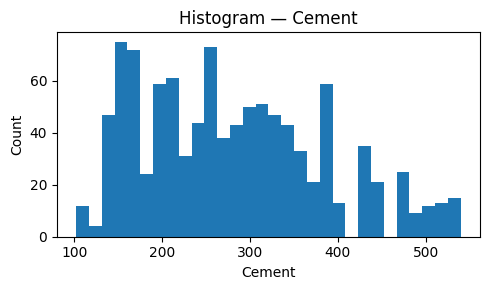

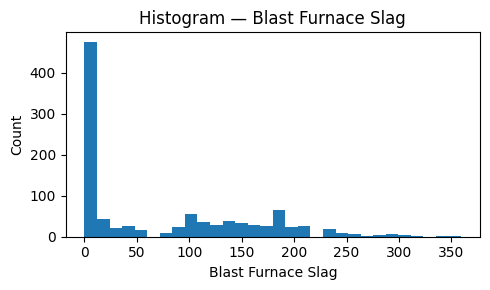

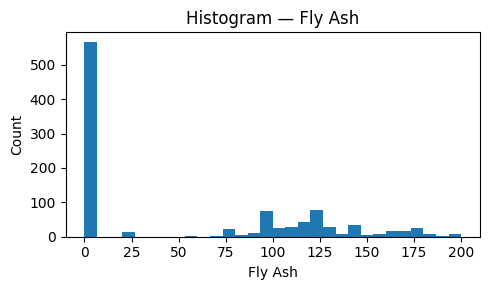

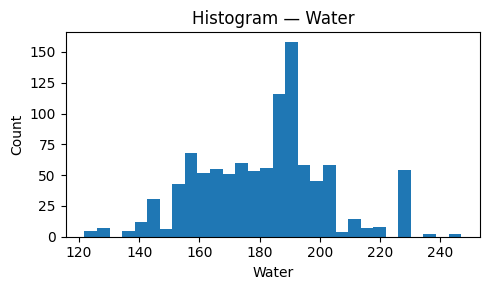

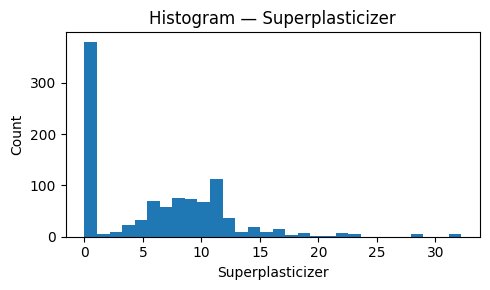

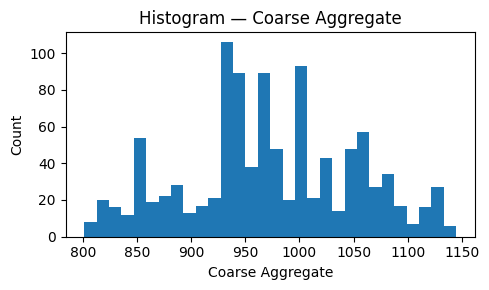

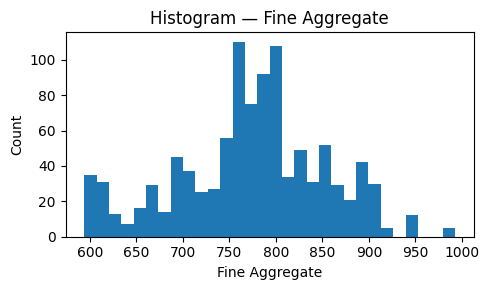

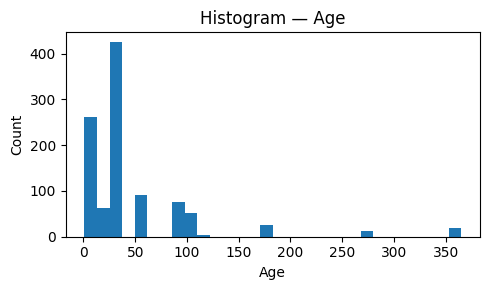

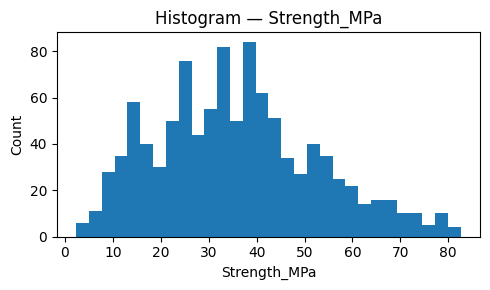

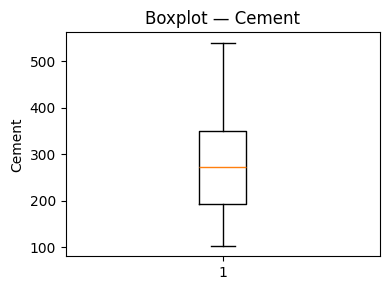

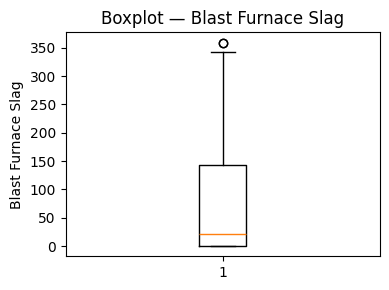

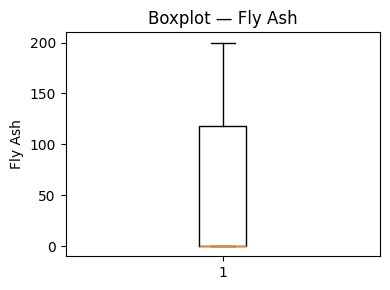

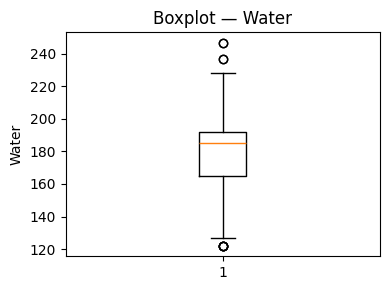

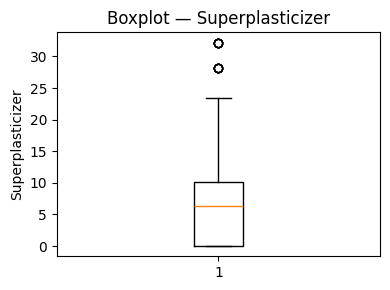

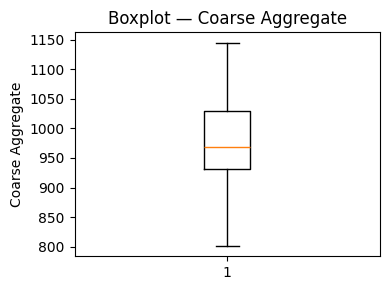

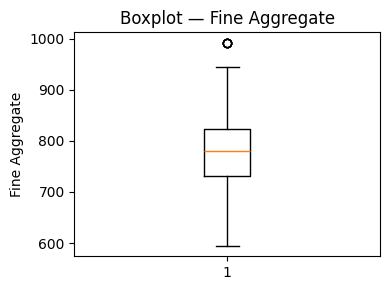

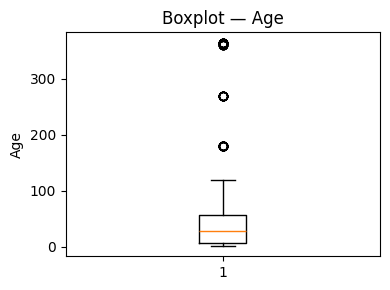

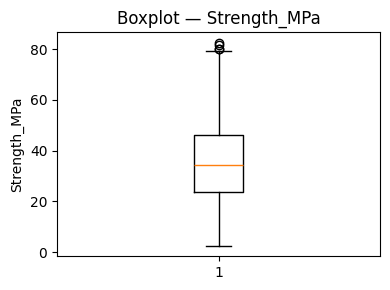

                        skew
Age                 3.269177
Superplasticizer    0.907203
Blast Furnace Slag  0.800717
Fly Ash             0.537354
Cement              0.509481
Strength_MPa        0.416977
Water               0.074628
Coarse Aggregate   -0.040220
Fine Aggregate     -0.253010


In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# 方便取名
df_eda = df.rename(columns={'Concrete compressive strength':'Strength_MPa'})

# 3-1) 直方圖（每欄各一張圖）
for col in df_eda.columns:
    plt.figure(figsize=(5,3))
    plt.hist(df_eda[col].values, bins=30)
    plt.title(f'Histogram — {col}')
    plt.xlabel(col); plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

# 3-2) 箱型圖（每欄各一張圖，看離群值）
for col in df_eda.columns:
    plt.figure(figsize=(4,3))
    plt.boxplot(df_eda[col].values, vert=True, whis=1.5)
    plt.title(f'Boxplot — {col}')
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

# 3-3) 偏度（skewness）快速檢查：>0 右偏、<0 左偏、|skew|>1 常視為高度偏態
skew_tbl = df_eda.apply(pd.Series.skew).sort_values(ascending=False).to_frame('skew')
print(skew_tbl)


步驟 4：關聯探索＋工程特徵

In [22]:
import numpy as np
eda = df.rename(columns={'Concrete compressive strength':'Strength_MPa'}).copy()

# 工程特徵
eda['binder']     = eda['Cement'] + eda['Blast Furnace Slag'] + eda['Fly Ash']
eda['w_c_ratio']  = eda['Water'] / eda['binder'].replace(0, np.nan)
eda['fine_ratio'] = eda['Fine Aggregate'] / (eda['Fine Aggregate'] + eda['Coarse Aggregate'])

# （可選）對高度右偏的 Age 做 log1p 觀察
eda['log_age'] = np.log1p(eda['Age'])


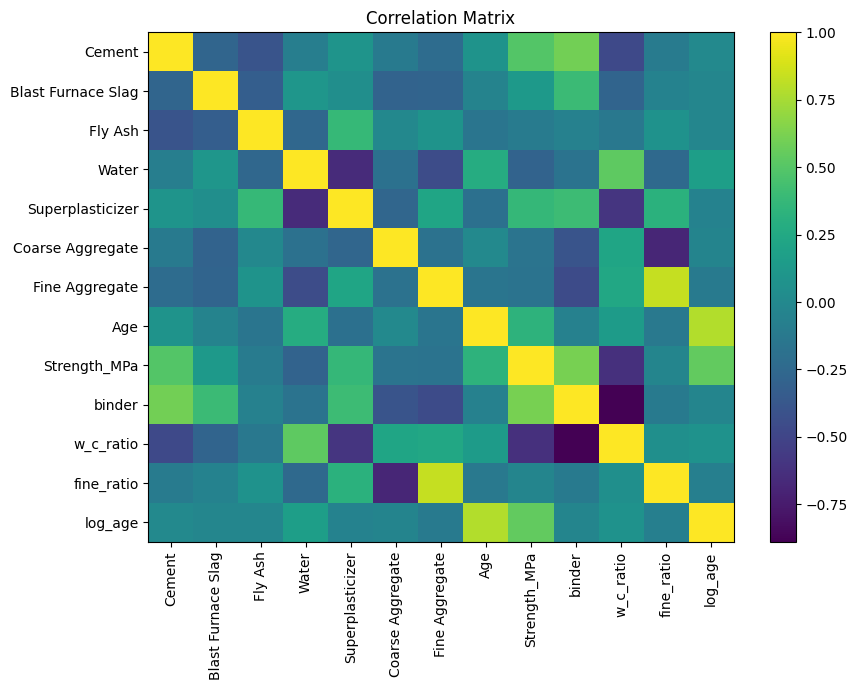

與 Strength_MPa 的相關係數（由高到低）：
 Strength_MPa          1.000000
binder                0.613184
log_age               0.549446
Cement                0.497832
Superplasticizer      0.366079
Age                   0.328873
Blast Furnace Slag    0.134829
fine_ratio           -0.029186
Fly Ash              -0.105755
Coarse Aggregate     -0.164935
Fine Aggregate       -0.167241
Water                -0.289633
w_c_ratio            -0.623087
Name: Strength_MPa, dtype: float64


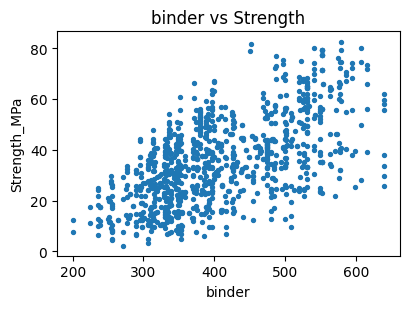

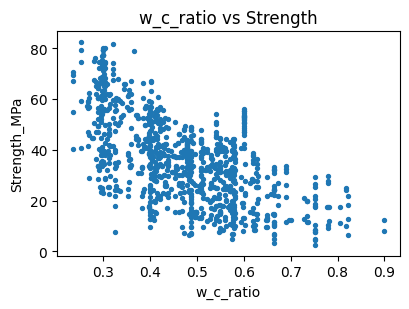

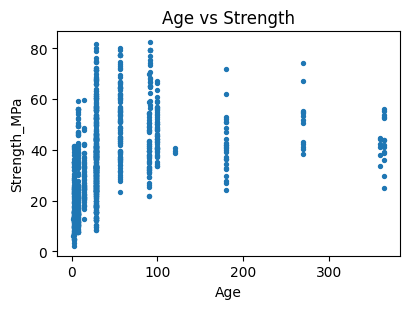

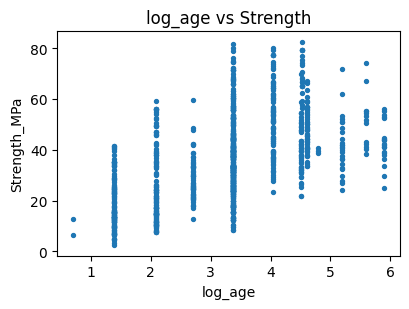

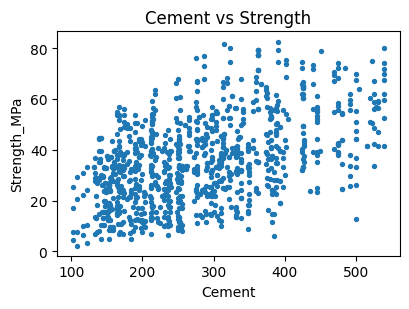

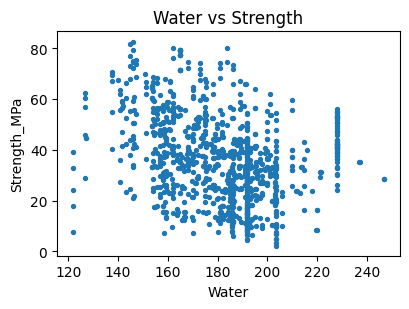

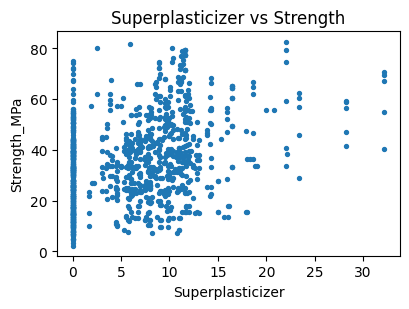

In [23]:
import matplotlib.pyplot as plt
import pandas as pd

# 只取數值欄位做相關
corr = eda.corr(numeric_only=True)

# 4-2a) 熱圖（快速看整體）
plt.figure(figsize=(9,7))
plt.imshow(corr, aspect='auto')
plt.colorbar(); plt.title("Correlation Matrix")
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.columns)
plt.tight_layout(); plt.show()

# 4-2b) 與 Strength_MPa 的相關排序（含工程特徵）
target = 'Strength_MPa'
corr_to_y = corr[target].sort_values(ascending=False)
print("與 Strength_MPa 的相關係數（由高到低）：\n", corr_to_y)

# 4-2c) 關鍵散佈圖（請重點觀察形狀是否非線性）
key_cols = ['binder', 'w_c_ratio', 'Age', 'log_age', 'Cement', 'Water', 'Superplasticizer']
for c in key_cols:
    if c in eda.columns:
        plt.figure(figsize=(4.2,3.2))
        plt.scatter(eda[c], eda[target], s=8)
        plt.xlabel(c); plt.ylabel('Strength_MPa'); plt.title(f'{c} vs Strength')
        plt.tight_layout(); plt.show()


步驟 5：Baseline 模型

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# 目標
y = eda['Strength_MPa']

# 選特徵（原始 + 工程特徵；你可依結果調整）
feat_cols = [
    'Cement','Blast Furnace Slag','Fly Ash','Water',
    'Superplasticizer','Coarse Aggregate','Fine Aggregate',
    'Age','log_age','binder','w_c_ratio','fine_ratio'
]
X = eda[feat_cols].copy()

# 可能的無窮/NaN（如 binder=0 導致 w_c_ratio NaN）
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median(numeric_only=True))

# 切分 Train / Val / Test = 70 / 15 / 15
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, 
                                                    random_state=42)
X_val,   X_test, y_val,  y_test  = train_test_split(X_temp, y_temp, 
                                                    test_size=0.50,
                                                     random_state=42)


In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math

lin_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', LinearRegression())
])

lin_pipe.fit(X_train, y_train)

def report(model, X_tr, y_tr, X_va, y_va, name):
    pred_tr = model.predict(X_tr)
    pred_va = model.predict(X_va)
    def m(y, p):
        mae  = mean_absolute_error(y, p)
        rmse = math.sqrt(((y - p)**2).mean())
        r2   = r2_score(y, p)
        return mae, rmse, r2
    print(f"\n[{name}]")
    print("Train  MAE / RMSE / R2 =", m(y_tr, pred_tr))
    print("Val    MAE / RMSE / R2 =", m(y_va, pred_va))

report(lin_pipe, X_train, y_train, X_val, y_val, "LinearRegression")



[LinearRegression]
Train  MAE / RMSE / R2 = (5.370684951005603, 6.869151432294247, 0.8326570194304824)
Val    MAE / RMSE / R2 = (5.561472870483135, 7.151604555169334, 0.8226562285918346)


In [26]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
report(rf, X_train, y_train, X_val, y_val, "RandomForest")



[RandomForest]
Train  MAE / RMSE / R2 = (1.2909232702485558, 1.9750331773183838, 0.9861659255146484)
Val    MAE / RMSE / R2 = (3.098386052411875, 4.647841644237068, 0.925094863280048)


In [27]:
def test_report(model, name):
    import math
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    pred = model.predict(X_test)
    mae  = mean_absolute_error(y_test, pred)
    rmse = math.sqrt(((y_test - pred)**2).mean())
    r2   = r2_score(y_test, pred)
    print(f"[{name}] TEST  MAE={mae:.3f}  RMSE={rmse:.3f}  R2={r2:.3f}")

test_report(lin_pipe, "LinearRegression")
test_report(rf,        "RandomForest")


[LinearRegression] TEST  MAE=5.473  RMSE=6.900  R2=0.810
[RandomForest] TEST  MAE=3.654  RMSE=5.166  R2=0.893


步驟 6｜建立 MLP（PyTorch）

In [28]:
import numpy as np, torch
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'

scaler = StandardScaler().fit(X_train.values)
Xtr = torch.tensor(scaler.transform(X_train.values), dtype=torch.float32)
Xva = torch.tensor(scaler.transform(X_val.values),   dtype=torch.float32)
Xte = torch.tensor(scaler.transform(X_test.values),  dtype=torch.float32)

ytr = torch.tensor(y_train.values, dtype=torch.float32).view(-1,1)
yva = torch.tensor(y_val.values,   dtype=torch.float32).view(-1,1)
yte = torch.tensor(y_test.values,  dtype=torch.float32).view(-1,1)

train_loader = DataLoader(TensorDataset(Xtr, ytr), batch_size=64, shuffle=True)
val_loader   = DataLoader(TensorDataset(Xva, yva), batch_size=256, shuffle=False)


In [29]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128), nn.ReLU(), nn.BatchNorm1d(128), nn.Dropout(0.1),
            nn.Linear(128, 64),     nn.ReLU(), nn.BatchNorm1d(64),  nn.Dropout(0.1),
            nn.Linear(64, 1)
        )
    def forward(self, x): return self.net(x)

model = MLP(in_dim=Xtr.shape[1]).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
loss_fn = nn.MSELoss()

best_val = float('inf')
best_state = None
patience, bad = 30, 0
train_hist, val_hist = [], []

for epoch in range(300):
    # train
    model.train(); total=0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        opt.step()
        total += loss.item()*xb.size(0)
    tr_loss = total/len(train_loader.dataset)

    # val
    model.eval(); total=0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            total += loss_fn(pred, yb).item()*xb.size(0)
    va_loss = total/len(val_loader.dataset)

    train_hist.append(tr_loss); val_hist.append(va_loss)

    if va_loss < best_val - 1e-5:
        best_val, bad = va_loss, 0
        best_state = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}
    else:
        bad += 1
        if bad >= patience:
            break

model.load_state_dict(best_state)
print("Best Val MSE:", best_val, "  (RMSE ≈", best_val**0.5, ")")


Best Val MSE: 18.356487274169922   (RMSE ≈ 4.284447137516103 )


In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math

def eval_split(X, y, name):
    model.eval()
    with torch.no_grad():
        pred = model(X.to(device)).cpu().squeeze().numpy()
    y_np = y.squeeze().numpy()
    mae  = mean_absolute_error(y_np, pred)
    rmse = math.sqrt(mean_squared_error(y_np, pred))
    r2   = r2_score(y_np, pred)
    print(f"[{name}] MAE={mae:.3f}  RMSE={rmse:.3f}  R2={r2:.3f}")
    return mae, rmse, r2

eval_split(Xva, yva, "MLP  Val")
eval_split(Xte, yte, "MLP  Test")


[MLP  Val] MAE=2.922  RMSE=4.284  R2=0.936
[MLP  Test] MAE=3.724  RMSE=5.299  R2=0.888


(3.724088, 5.2993595744017705, 0.8877927660942078)

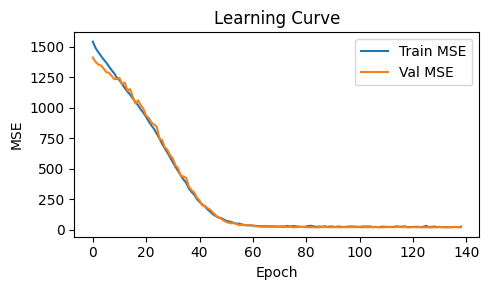

In [31]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,3))
plt.plot(train_hist, label='Train MSE'); plt.plot(val_hist, label='Val MSE')
plt.legend(); plt.title("Learning Curve"); plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.tight_layout(); plt.show()
